# Exercise 11.1

As a first step I import all the needed libraries.

In [2]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt

## Data generation 
Now let's generate the data, I will add some noise (sigma = 0.2) in order to make the data more "real": in true life application we always have some noise. 

In [5]:
# target parameters of f(x) = m*x + b
m = 2 # slope
b = 1 # intersect

# generate training inputs
np.random.seed(0)
x_train = np.random.uniform(-1, 1, 100)
x_valid = np.random.uniform(-1, 1, 10)
x_valid.sort()
y_target = m * x_valid + b # ideal (target) linear function

sigma = 0.2 # noise standard deviation, for the moment it is absent
y_train = np.random.normal(m * x_train + b, sigma) # actual measures from which we want to guess regression parameters
y_valid = np.random.normal(m * x_valid + b, sigma)

Visualize the data 

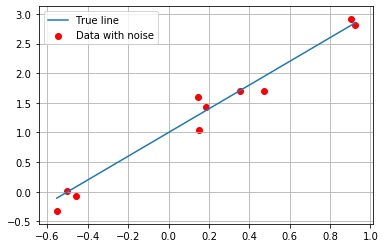

In [6]:
# plot training and target dataset
import matplotlib.pyplot as plt
plt.plot(x_valid, y_target, label="True line")
plt.scatter(x_valid, y_valid, color='r',label="Data with noise")
plt.legend()
plt.grid(True); plt.show()

## Data preprocessing

Machine learning always need some kind of data preprocessing. Normally, data should be normalized or scaled in a specific range. This is particulary important in order to make the algorithm able to generalize well on unseen data, especially if the new data lies on an unexplored range. Furthermore, machine learning libraries are written in a way that expects normalized data, in some way: they may perform badly on data that it is not.

Usually, regression problems require normally distributed features (gaussian centred on zero, with unit variance), and I will do so.

In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_scal = scaler.fit_transform(x_train.reshape(-1,1))
x_valid_scal = scaler.transform(x_valid.reshape(-1,1))

This simple shrewdness can really change results (since the way keras is implemented). In the following figures you can see how the neuron perform on unnormalized and normalized validation data. Both fits have been done with batch size of 32, 30 epochs and stochastic gradient descent and no noisy data.

<img src="not_norm.png"> <img src="norm.png">

This simple trick is almost enough to have a very good performing neuron (and some more epochs will do the rest!).

## Building the neural network

The model should be very simple, and is actually so simple that no tricky optimizer should be needed, the plain stochastic gradient descent is enough and I will not change it. Some more epochs than the 30 of the example may be necessary, I will try with 50.

In [8]:
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects

model = keras.Sequential()
model.add(Dense(1, input_shape=(1,)))

# compile the model choosing optimizer, loss and metrics objects
model.compile(optimizer='sgd', loss='mse', metrics=['mse'], )

W0711 19:04:29.788876 140089385768576 __init__.py:308] Limited tf.compat.v2.summary API due to missing TensorBoard installation.
W0711 19:04:30.185673 140089385768576 deprecation.py:506] From /usr/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [9]:
#since on this dataset is very easy to overfit, I use the early stopping
from tensorflow.contrib.keras.api.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)


history = model.fit(x=x_train_scal, y=y_train, 
          batch_size=32, epochs=50,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x_valid_scal, y_valid),  callbacks=[es])

Train on 100 samples, validate on 10 samples
Epoch 1/50
100/100 [==============================] - 0s 2ms/sample - loss: 8.9718 - mean_squared_error: 8.9718 - val_loss: 8.9598 - val_mean_squared_error: 8.9598
Epoch 2/50
100/100 [==============================] - 0s 295us/sample - loss: 7.6695 - mean_squared_error: 7.6695 - val_loss: 7.3683 - val_mean_squared_error: 7.3683
Epoch 3/50
100/100 [==============================] - 0s 234us/sample - loss: 6.3593 - mean_squared_error: 6.3593 - val_loss: 6.3001 - val_mean_squared_error: 6.3001
Epoch 4/50
100/100 [==============================] - 0s 153us/sample - loss: 5.4517 - mean_squared_error: 5.4517 - val_loss: 5.2370 - val_mean_squared_error: 5.2370
Epoch 5/50
100/100 [==============================] - 0s 232us/sample - loss: 4.5648 - mean_squared_error: 4.5648 - val_loss: 4.5249 - val_mean_squared_error: 4.5249
Epoch 6/50
100/100 [==============================] - 0s 158us/sample - loss: 3.9353 - mean_squared_error: 3.9353 - val_loss: 3

Epoch 50/50
100/100 [==============================] - 0s 193us/sample - loss: 0.0432 - mean_squared_error: 0.0432 - val_loss: 0.0327 - val_mean_squared_error: 0.0327


In [10]:
# evaluate model
score = model.evaluate(x_valid_scal, y_valid, batch_size=32, verbose=1)

# print performance
print()
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])
nn_perf=score[1]

10/10 [==============================] - 0s 277us/sample - loss: 0.0327 - mean_squared_error: 0.0327

Validation loss: 0.03269707411527634
Validation accuracy: 0.032697074


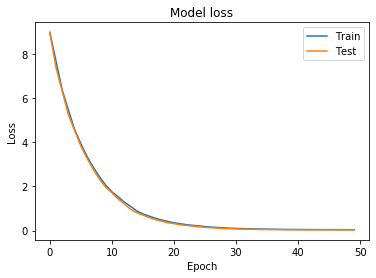

In [11]:
# look into training history
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

From the graph of the loss is clear that 50 ephocs are quite too much: maybe 40 are enough. Furtermore you can note how the losses on training and on test are almost the same, from my experience usually in deep learning applications this is never a good thing, but it's true that the model is very much simpler than the one that usually neural networks are used to train on...

## Comparing predicted data with true data 

In the following I compare predicted data in the validation set.

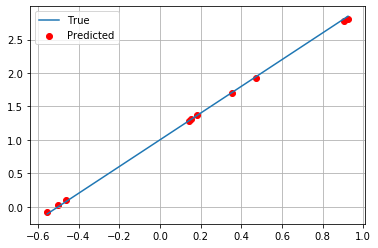

In [12]:

y_predicted = model.predict(x_valid_scal)

#unnormalize data:
x_valid_rev=scaler.inverse_transform(x_valid_scal)

plt.scatter(x_valid_rev, y_predicted,color='r', label="Predicted")
plt.plot(x_valid_rev, y_target, label="True")
plt.legend()
plt.grid(True)
plt.show()

## Note
Neural networks are suitable for non-linear problems. For linear problems neural networks are actually bad performing and ''classical'' machine learning approches usually outperforms them.

In the following lines I try a different model, simpler and faster. 
I will use sklearn, that implements almost all the "classical" machine learning approches.

In [11]:
from sklearn.linear_model import LinearRegression
simple_model = LinearRegression()

#x_train=x_train.reshape(-1, 1); #sklearn wants multi-dim array

In [12]:
regression=simple_model.fit(x_train_scal,y_train)


## Performance
Mean squared error on validation set shows that this model, on this simple data set, is almost perfect.

In [13]:
from sklearn.metrics import mean_squared_error

y_pred=simple_model.predict(x_valid_scal)
reg_perf=mean_squared_error(y_valid, y_pred)

print("Neural network MSE (Validation set)\t", nn_perf)
print("Regression MSE(Validation set):\t\t", reg_perf)

Neural network MSE (Validation set)	 0.031787865
Regression MSE(Validation set):		 0.0327813706160902


## Visualizing results on validation set

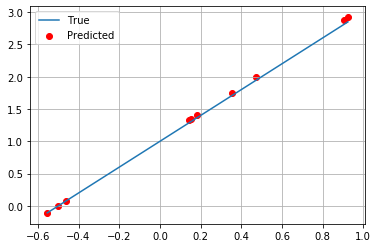

In [14]:

y_predicted = simple_model.predict(x_valid_scal)

X_v=scaler.inverse_transform(x_valid_scal)
X_t=scaler.inverse_transform(x_train_scal)

plt.scatter(X_v, y_predicted,color='r', label="Predicted")

plt.plot(X_v, y_target, label="True")
plt.legend()
plt.grid(True)
plt.show()